In [11]:
import pandas as pd
import conorm
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np

In [12]:
df = pd.read_csv('HTSeq_count_combined_with_header.tsv', sep='\t')
df = df.set_index('geneName')

In [13]:
# calculate counts per million
cpm_df=conorm.cpm(df)
# filter low experssed genes: only include genes with cpm>0.5 in at least 20% samples
n = df.shape[1]
cpm_df['count'] = cpm_df[cpm_df > 0.5].count(axis=1)
df_highexpressed=cpm_df[cpm_df['count']>n*0.2]


In [15]:
# subset groups according to TCGA labels
tumor = df_highexpressed.filter(regex='.*-[0,1]\dA')
normal = df_highexpressed.filter(regex='.*-1\dA')
control = df_highexpressed.filter(regex='.*-2\dA')

In [16]:
# normalize counts using tmm
tumor_tmm = conorm.tmm(tumor)
normal_tmm = conorm.tmm(normal)

In [17]:
# compute t-test and FDR to filter genes have siginificant level <0.001
t_test = {}
for i in tumor_tmm.T:   
    t_test[i] = stats.ttest_ind(tumor_tmm.T[i], normal_tmm.T[i], equal_var= False, nan_policy='omit')
t_test = pd.DataFrame.from_dict(t_test).T
t_test.columns = ['t_statistics', 'p_value']
# FDR
p_adjusted = multipletests(pvals=t_test["p_value"], alpha=0.05, method='fdr_bh',is_sorted = False, returnsorted = False)
t_test['Adjusted_p'] = p_adjusted[1]
t_test = t_test.loc[(t_test["Adjusted_p"] < 0.001)]
t_test.index.name = 'geneName'

In [18]:
# merge groups with p-values
tmm = pd.concat([tumor_tmm,normal_tmm],axis=1)
tmm_with_pvalues =pd.merge(left = tmm, right=t_test,left_on='geneName',right_on = 'geneName', how = 'inner')

In [19]:
# calculate fold change using normalized data
normal_tmm['mean'] = normal_tmm.mean(axis=1)
tumor_tmm['mean'] = tumor_tmm.mean(axis=1)
tmm_with_pvalues['fold_change'] = np.log2(tumor_tmm['mean'] / normal_tmm['mean'])
deg = tmm_with_pvalues.loc[(tmm_with_pvalues['fold_change'] > 2)]

In [ ]:
# Label the classes for deg
index = deg.index.insert(0, "Disease_state")
deg.loc["new", :] = np.nan
deg = deg.shift(1)
deg.index = index

for i in range(len(deg.columns)):
    val = float(deg.columns[i][13:15])
    if val >=0 and val <= 9:
        deg.iloc[0, i] = 1
    else:
        deg.iloc[0, i] = 0

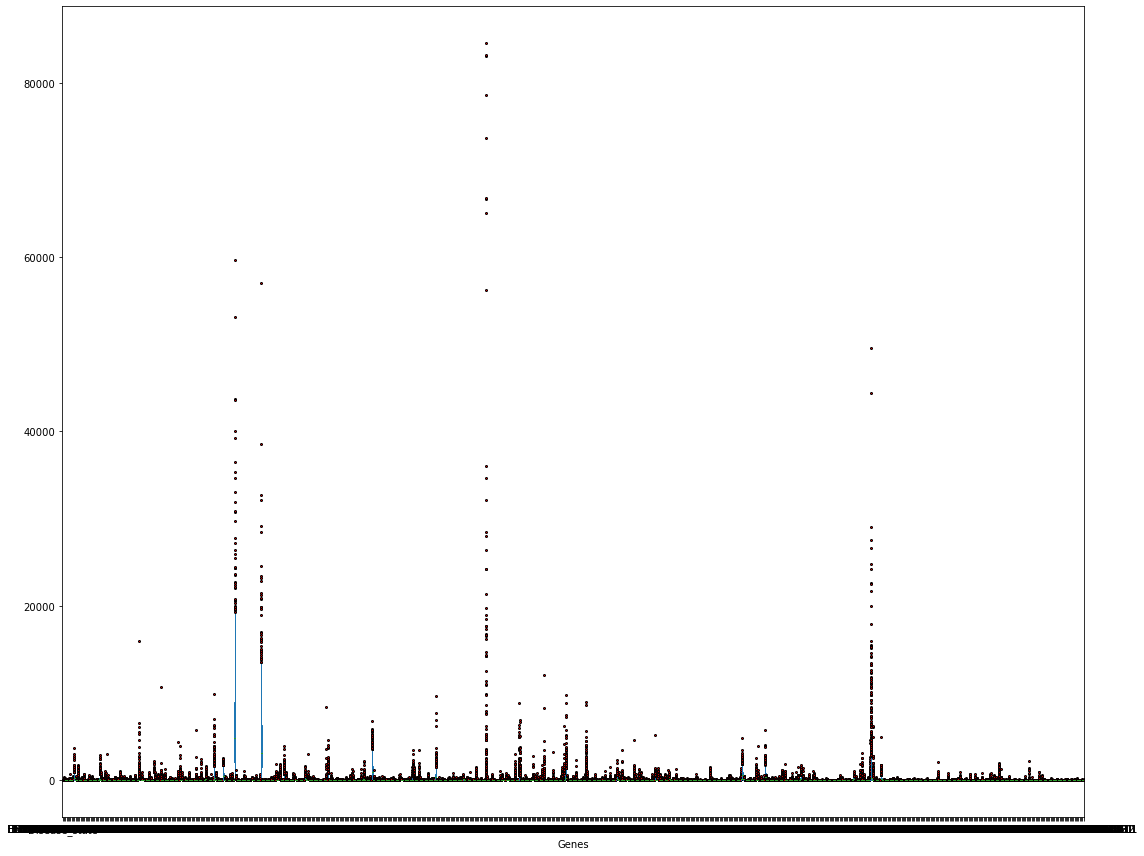

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
deg.T.boxplot(grid=False, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'r'})
plt.xlabel('Genes')
plt.tight_layout()
plt.show()

In [51]:
# Transform DEG
deg = deg+1
deg =np.log2(deg)

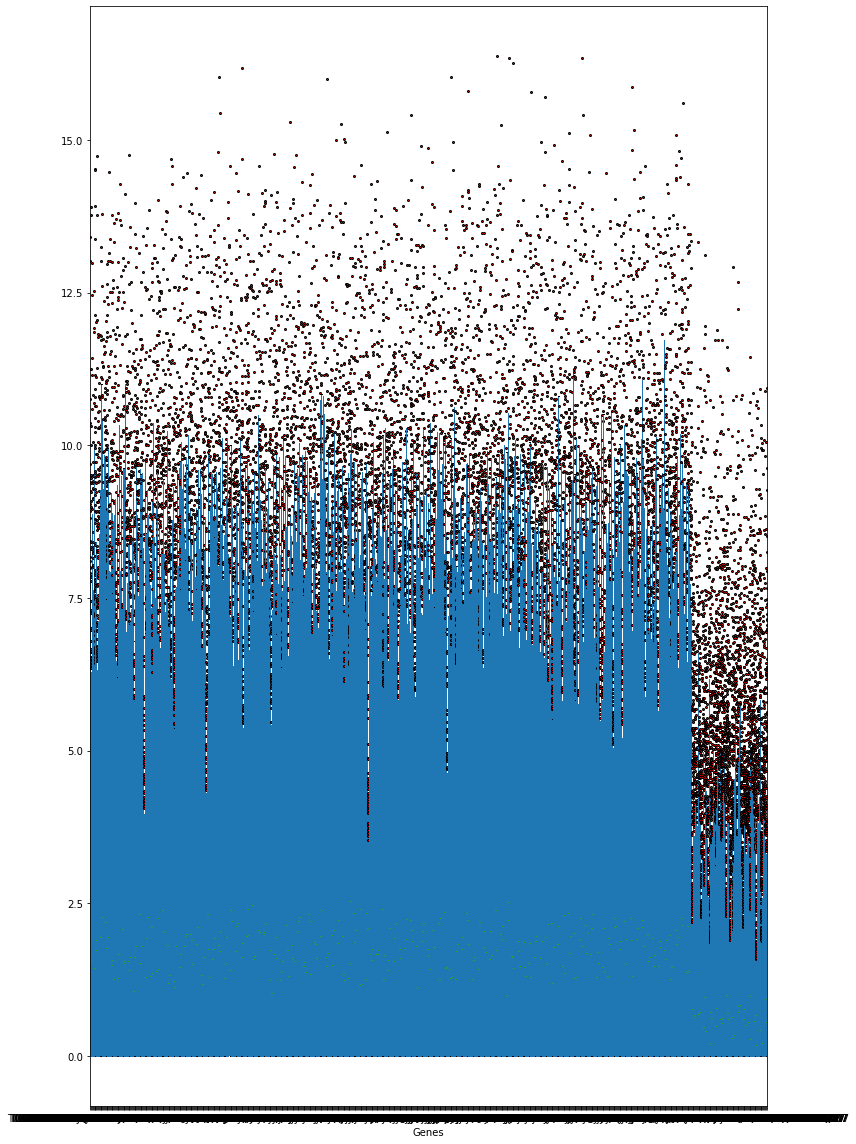

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,16))
deg.boxplot(grid=False, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'r'})
plt.xlabel('Genes')
plt.tight_layout()
plt.show()

In [61]:
tumor_deg = deg.filter(regex='.*-0\dA')
normal_deg = deg.filter(regex='.*-1\dA')

In [62]:
tumor_deg.to_csv('Tumor_deg_p0.001_FC2.csv')
normal_deg.to_csv('Normal_deg_p0.001_FC2.csv')
deg.to_csv('Normalized_DEG_p0.001_FC2.csv')